# Table of content


* [Import required packages](#import)
* [Part 1.](#part1)
        * [1.1. Load login data](#load)
        * [1.2. Agreggate the data in 15-min interval](#agg)
        * [1.3. Is our data stationary?](#stationary)
        * [1.4. Data visualize the important features](#vis)
* [Part 2.](#part2)
        * [Question](#question)
        * [Answer](#answer)
* [Part 3.](#part3)
        * [3.1. Data wrangling](#dw)
        * [3.2. Exploratory data analysis](#eda)
        * [](#)


## Import required packages <a class='anchor' id='import'><a/>

In [8]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# time-series imports
from datetime import datetime

from statsmodels.tsa import seasonal
from statsmodels.tsa.stattools import adfuller

from datetime import timedelta
from datetime import date

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

import itertools

import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer


## Part 1 <a class='anchor' id='part1'><a/>
    
We have a json file containing (simulated) timestamps of user logins in a particular geographic location. We are asked to:
    
    
1. Aggregate the data based on 15­minute time intervals
    
2. Visualize and describe the resulting time series in ways that best characterize the underlying patterns
    
3. Report/illustrate important features of the demand, such as daily cycles.
    
4. If there are data quality issues, please report them.

## 1.1. Load login data <a class='anchor' id='load'><a/>

Using pd.read_jason(), I open the login data file and load its data in a pandas dataframe.

In [2]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#Check to see if data is missing
logins.isna().sum()

login_time    0
dtype: int64

There is no missing data, now I use describe()

In [4]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


The data is from 01/01/1970 to /04/04/1970. Next I set _login_time_ as the index and convert it to datetime.

In [5]:
logins = logins.set_index(pd.to_datetime(logins['login_time']))
logins['Count'] = 1
logins.drop(columns='login_time', axis=1, inplace=True)
logins.head()

,Count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


### 1.2. Agreggate the data in 15-min interval <a class='anchor' id='agg'><a/>

The question has asked for aggregating the login data into 15-minute interval. I will do so by using resample()

In [6]:
# Aggregate in 15-min intervals

login_15 = pd.DataFrame(logins.Count.resample('15Min').sum())
login_15.head()

,Count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
# ChecK for missing data

login_15.isna().sum()

Count    0
dtype: int64

I will plot the 15-min login data 

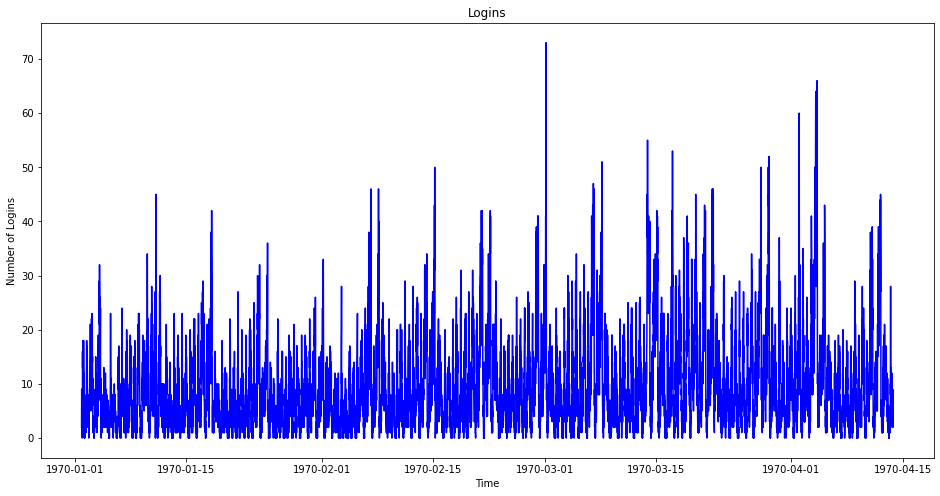

In [8]:
# Plot 15-min logins

fig, ax=plt.subplots(figsize=(16,8))
ax.plot(login_15.index, login_15['Count'], color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Logins')
ax.set_title('Logins')
plt.show()

## 1.3. Is our data stationary? <a class='anchor' id='stationary'><a/>

I do a Dickery Fuller test to see if the daily login data is stationary. Statinary means that the data does not change with time or better say, mean and variance stay the same overtime.

In [10]:
# Run Dickery Fuller test to check stationary
logins_daily = pd.DataFrame(logins.Count.resample('D').sum())

adfuller(logins_daily)

(-1.403316491921988,
 0.5806851218557992,
 13,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 1173.2398848029677)

The null hypothesis in Dickey Fuller test is that the data is not statinary. Here the p-value is 0.58, assuming 95% confisence interval, we fail to reject the null hypothesis. Therefore, data is not stationary and it changes with time. In the next step we I use _statsmodel seasonal decompose_ to see elements of the time series.

I am using daily logins with period of 7 (number of days in a week), and additive model.

Text(0.5, 1.0, 'total log-ins residuals')

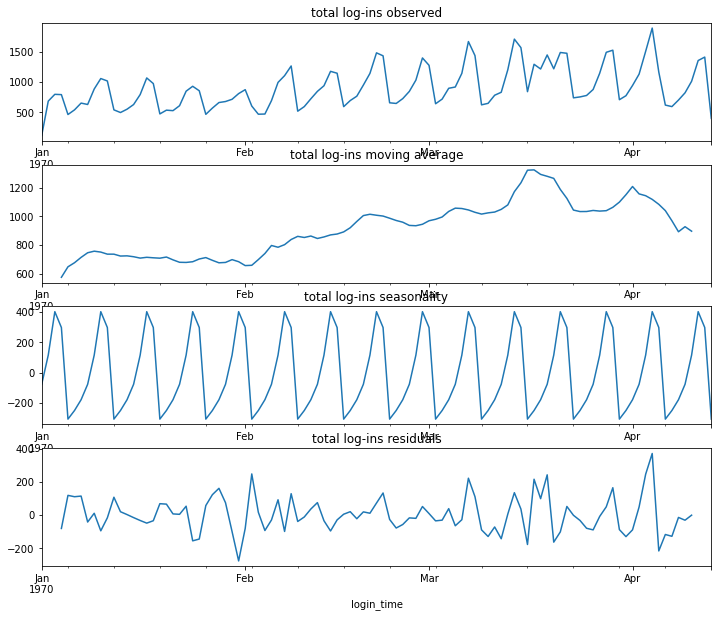

In [11]:
# Decompose daily-login series and plot

r = seasonal.seasonal_decompose(logins_daily.Count, model='additive', period=7)

# Plot gathered statistics
fig, (axes0, axes1, axes2, axes3) = plt.subplots(4,1, figsize=(12,10))

r.observed.plot(ax=axes0)
axes0.set_title('total log-ins observed')

r.trend.plot(ax=axes1)
axes1.set_title('total log-ins moving average')

r.seasonal.plot(ax=axes2)
axes2.set_title('total log-ins seasonality')

r.resid.plot(ax=axes3)
axes3.set_title('total log-ins residuals')


From above plots, I can see that the mean value of daily logins is increasing overtime, which confirms the results of Dickey Fuller test that the data in not stationary. From the seasonalty plot, we can clearly see that there is seasonal pattern in the data. Next I try to visualize this pattern more sensibly. I define two dataframes: hourly and daily to show what day of the week and what hour logins have taken place.

## 1.4. Data visualize the important features <a class='anchor' id='vis'><a/>

In [12]:
# Define a dataframe daily which shows the day of the week.

daily = pd.DataFrame(logins.Count.resample('D').sum())
daily['Day of the week'] = daily.index.weekday
daily.head()


,Count,Day of the week
login_time,,
1970-01-01,112,3
1970-01-02,681,4
1970-01-03,793,5
1970-01-04,788,6
1970-01-05,459,0


In [13]:
# Define a dataframe hourly that shows the hour of the day

hourly = pd.DataFrame(logins.Count.resample('H').sum())
hourly['Hour of the day'] = hourly.index.hour
hourly.head()

,Count,Hour of the day
login_time,,
1970-01-01 20:00:00,24,20
1970-01-01 21:00:00,9,21
1970-01-01 22:00:00,21,22
1970-01-01 23:00:00,58,23
1970-01-02 00:00:00,53,0


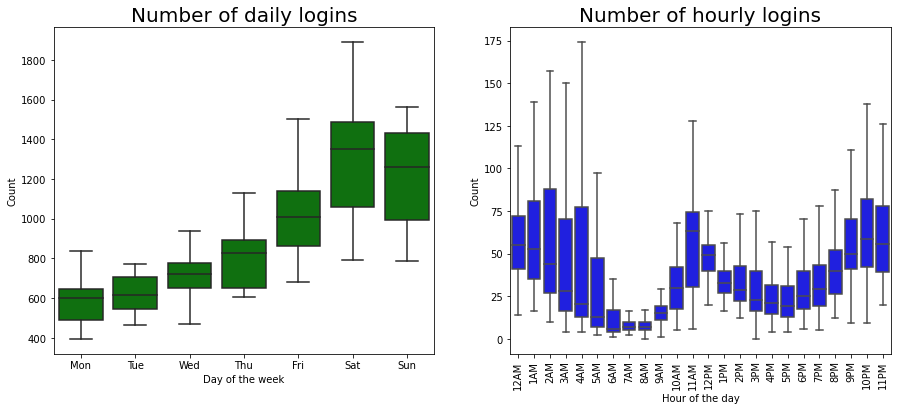

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(y='Count', x='Day of the week', ax=ax[0], data=daily, showfliers = False, color='green')
ax[0].set_title('Number of daily logins', fontsize = 20, loc='center')
ax[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

sns.boxplot(y='Count', x='Hour of the day', ax=ax[1], data=hourly, showfliers = False, color='blue')
ax[1].set_title('Number of hourly logins', fontsize = 20, loc='center')
ax[1].set(xlabel='Hour of the day')
ax[1].set_xticklabels(['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM',
                      '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM'], rotation=90)
print('')

__Daily logins__: As shown in the daily login plot, Saturday, followed by Sunday are the busiest days of the week. Starting from Monday the number of people using the system increases and it reaches its peak on Saturday. There is also more variability in number of users on Saturdays and sundays; while the average of daily logins in these days are higher than the rest of the week, they both have a longer box meaning that there is a bigger difference between 25% and 75%. 

__Hourly logins__: The hourly logins has _w_ shape. Starting from 12 AM, the number of logins decreses and reaches a minimum at 7 and 8 AM. Then it increases and reaches its maximum at 11 AM, followed by another decline and increase; the login reaches its second minum at around 5pm and increases again after that.

It seems during lunch time, 11 am, people tend to login more as well as between 9 pm to 2 am.

# Part 2 <a class='anchor' id='part2'><a/>

## 2.1. Question <a class='anchor' id='question'><a/>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the


proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the observation
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

## 2.2. Answer <a class='anchor' id='answer'> </a>

In order for any experiment to be meaningful, we need to have two groups: a) control and b) test groups. In this example __I am assuming that we have access to records of drivers' travel history (ie the pick-up place and the destination, the time etc).__ I divide trips a driver makes into two categories: 1. internal and 2 external. Interal trips happen inside the driver's original city (pick-up and desination are both in the driver's original city) and external trips are those commutes which involve the other city (pick-up and/or desination is in the other city).  For each driver, I then calculate the ratio of the external trips which is: the number of external trips to the total trips a driver makes. I then randomly divide the drivers into two groups and findean of 
The control group will continue normal operation but the test group will be informed of the reimbursment program. After a certain time, we can compare the two groups by looking at the travel history of the two groups. If the average number of external travel  the test group is higher than the control group, we can conclude the program has been successful. For the test, it should be comparison of means with a one-sided t-test.

    


# Part 3 <a class='anchor' id='part3'><a/>

WE have a json file of users who used the service in the last six months. A user is considered a _retained_ user if the had a trip within the previous 30 days. We are asked to 

1. Perform cleaning, exploratory analysis and visualize the data

2. Build a predictive model to help Ultimate determine whether or not a user will be active

3. Briefly discuss how Ultimate might leverage the insights gained from the model to

The features that are included in the data are:

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekda

Here is my approch:
    1. Data wrangling and check if anything is missing
    
    2. Convert the data into features that I can use in modeling
    
    3. Find the retained user
    
    4. Perform EDA and visualize the data
    
    5. Perform PCA to understand the data better
    
    5. Perform preprocessing which includes, imputing the missing data, scale the data and change categorical data to numerical columns
    
    6. Train a model
    
    7. 

## 3.1. Data wrangling <a class='anchor' id='dw'><a/>

In [9]:
df = pd.read_json('ultimate_data_challenge.json')
print(df.shape)
df.head()

(50000, 12)


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


Checking to see if there is any missing data.

In [ ]:
# Check for missing data

plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)

In [3]:
missing1 = df.isnull().sum()
missing2 = 100*df.isnull().mean()
missing = pd.concat([missing1, missing2], axis=1)
missing.columns = ['count', '%']
missing

,count,%
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_rating_of_driver,8122,16.244
avg_surge,0,0.000
last_trip_date,0,0.000
phone,396,0.792
surge_pct,0,0.000
ultimate_black_user,0,0.000
weekday_pct,0,0.000


In [6]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [4]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [10]:
# Change to datetime tpye
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [11]:
print('Sign up had happened between {} and {}.'.format(df['signup_date'].min(), df['signup_date'].max()))

Sign up had happened between 2014-01-01 00:00:00 and 2014-01-31 00:00:00.


In [12]:
print('The last trip day is {}.'.format(df['last_trip_date'].max()))

The last trip day is 2014-07-01 00:00:00.



It can be seen that signing up have happened during January and the last trip taken is on first of July. We can conclude the July 1 is the day that they have collected the data from the system. Therefore, according to the _retention_ definition (being active in the preceding 30 days) any custor who had a trip durin month of June is a retained user. In the next step, whe define a function to check the retention criterion and define a column called _if_retained_ which is either 0 or 1 to show if the user is a retained user (1) or nor (0).  


In [13]:
def retained_user(x):
    date1 = date(2014,6,1)
    date2 = date(2014,6,30)
    if_retained = 0
    if x <= date2 and x >= date1:
        if_retained = 1
    return if_retained      


In [14]:
df['if_retained'] = df['last_trip_date'].apply(retained_user)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,if_retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [15]:
df['if_retained'].value_counts()/len(df)

0    0.63488
1    0.36512
Name: if_retained, dtype: float64

## 3.2. Exploratory data analysis <a class='anchor' id='eda'><a/>

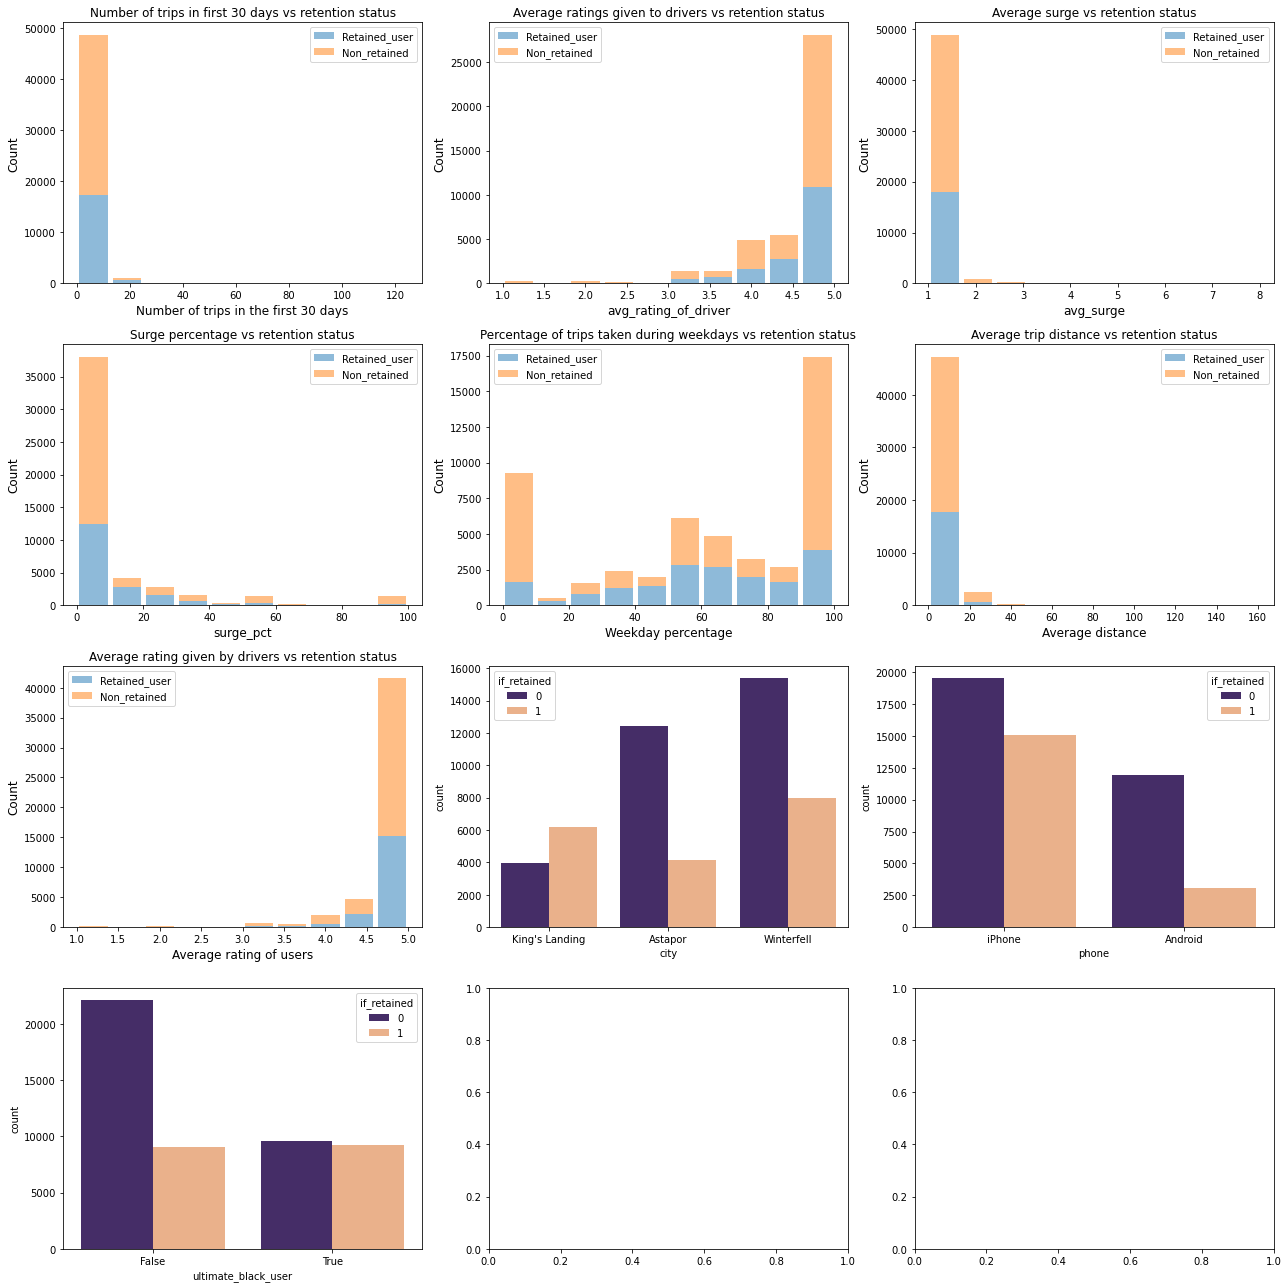

In [26]:
fig, ((axes0, axes1, axes2), (axes3, axes4, axes5), (axes6, axes7, axes8), (axes9, axes10, axes11)) = plt.subplots(nrows = 4, ncols = 3, figsize=(18,25))

s1 = pd.DataFrame({'Retained_user': df.loc[df['if_retained']==1, 'trips_in_first_30_days'], 'Non_retained': df.loc[df['if_retained']==0, 'trips_in_first_30_days']}, index=None)
s1.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(18,20), ax=axes0, alpha=.5)

s2 = pd.DataFrame({'Retained_user': df.loc[df['if_retained']==1, 'avg_rating_of_driver'], 'Non_retained': df.loc[df['if_retained']==0, 'avg_rating_of_driver']}, index=None)
s2.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(18,12), ax=axes1, alpha=.5)

s3 = pd.DataFrame({'Retained_user': df.loc[df['if_retained']==1, 'avg_surge'], 'Non_retained': df.loc[df['if_retained']==0, 'avg_surge']}, index=None)
s3.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(18, 12), ax=axes2, alpha=.5)

s4 = pd.DataFrame({'Retained_user': df.loc[df['if_retained']==1, 'surge_pct'], 'Non_retained': df.loc[df['if_retained']==0, 'surge_pct']}, index=None)
s4.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(18, 12), ax=axes3, alpha=.5)

s5 = pd.DataFrame({'Retained_user': df.loc[df['if_retained']==1, 'weekday_pct'], 'Non_retained': df.loc[df['if_retained']==0, 'weekday_pct']}, index=None)
s5.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(18, 12), ax=axes4, alpha=.5)

s6 = pd.DataFrame({'Retained_user': df.loc[df['if_retained']==1, 'avg_dist'], 'Non_retained': df.loc[df['if_retained']==0, 'avg_dist']}, index=None)
s6.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(18, 12), ax=axes5, alpha=.5)

s7 = pd.DataFrame({'Retained_user': df.loc[df['if_retained']==1, 'avg_rating_by_driver'], 'Non_retained': df.loc[df['if_retained']==0, 'avg_rating_by_driver']}, index=None)
s7.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(18, 18), ax=axes6, alpha=.5)


sns.countplot(x="city", hue='if_retained', data=df, palette=['#432371',"#FAAE7B"], ax=axes7)
sns.countplot(x="phone", hue='if_retained', data=df, palette=['#432371',"#FAAE7B"], ax=axes8)
sns.countplot(x="ultimate_black_user", hue='if_retained', data=df, palette=['#432371',"#FAAE7B"], ax=axes9)

axes0.legend(['Retained_user', 'Non_retained'])
axes0.set_xlabel('Number of trips in the first 30 days', fontsize=12)
axes0.set_ylabel('Count', fontsize=12)
axes0.set_title("Number of trips in first 30 days vs retention status", fontsize=12)

axes1.legend(['Retained_user', 'Non_retained'])
axes1.set_xlabel('avg_rating_of_driver', fontsize=12)
axes1.set_ylabel('Count', fontsize=12)
axes1.set_title("Average ratings given to drivers vs retention status", fontsize=12)

axes2.legend(['Retained_user', 'Non_retained'])
axes2.set_xlabel('avg_surge', fontsize=12)
axes2.set_ylabel('Count', fontsize=12)
axes2.set_title("Average surge vs retention status", fontsize=12)

axes3.legend(['Retained_user', 'Non_retained'])
axes3.set_xlabel('surge_pct', fontsize=12)
axes3.set_ylabel('Count', fontsize=12)
axes3.set_title("Surge percentage vs retention status", fontsize=12)

axes4.legend(['Retained_user', 'Non_retained'])
axes4.set_xlabel('Weekday percentage', fontsize=12)
axes4.set_ylabel('Count', fontsize=12)
axes4.set_title("Percentage of trips taken during weekdays vs retention status", fontsize=12)

axes5.legend(['Retained_user', 'Non_retained'])
axes5.set_xlabel('Average distance', fontsize=12)
axes5.set_ylabel('Count', fontsize=12)
axes5.set_title("Average trip distance vs retention status", fontsize=12)

axes6.legend(['Retained_user', 'Non_retained'])
axes6.set_xlabel('Average rating of users', fontsize=12)
axes6.set_ylabel('Count', fontsize=12)
axes6.set_title("Average rating given by drivers vs retention status", fontsize=12)



plt.tight_layout()
plt.show()    

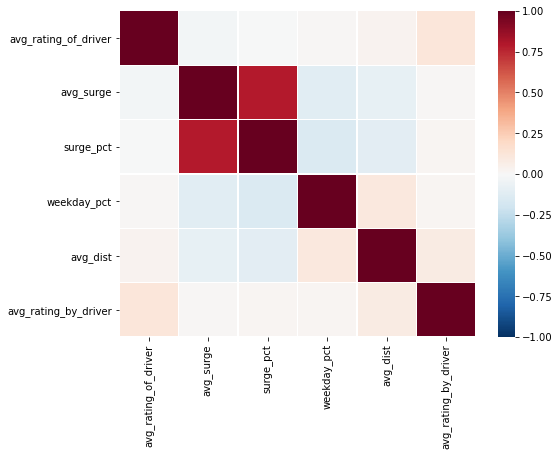

In [27]:
dffloat = df.select_dtypes(include=['int', 'float'])
plt.subplots(figsize=(8,6))
corr = dffloat.corr()
sns.heatmap(corr ,xticklabels=corr.columns, yticklabels=corr.columns,cmap="RdBu_r",linewidths=.15,vmin=-1, vmax=1);

<AxesSubplot:ylabel='Frequency'>

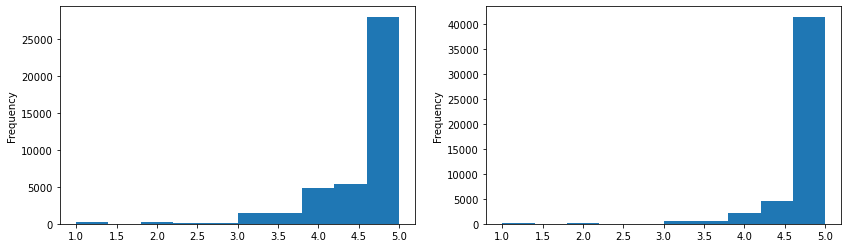

In [28]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
df['avg_rating_of_driver'].plot.hist(ax=ax0)
df['avg_rating_by_driver'].plot.hist(ax=ax1)

In [29]:
dffloat = df.select_dtypes(include=['int', 'float'])
values = {'avg_rating_of_driver': df['avg_rating_of_driver'].median(), 'avg_rating_by_driver': df['avg_rating_by_driver'].median()}
dffloat.fillna(value = values, inplace=True)

In [30]:
dffloat.isna().sum()

avg_rating_of_driver    0
avg_surge               0
surge_pct               0
weekday_pct             0
avg_dist                0
avg_rating_by_driver    0
dtype: int64

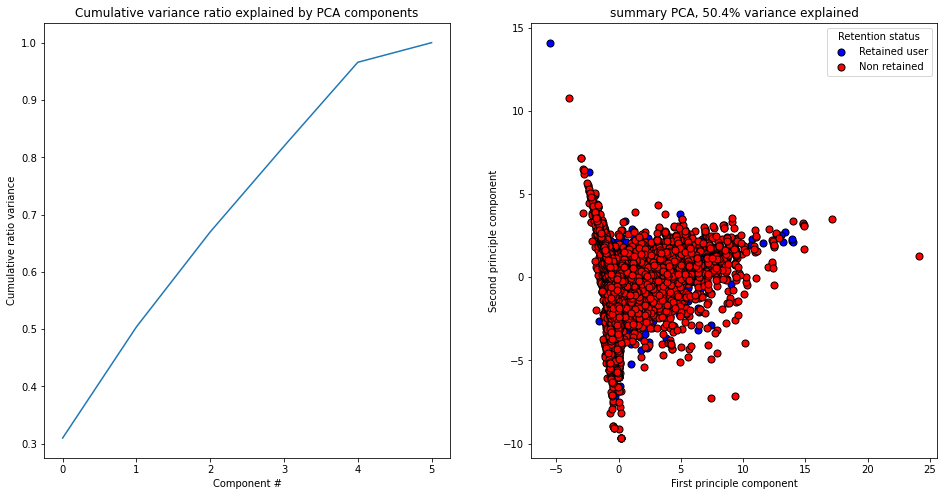

In [31]:
Y = df['if_retained']
X = dffloat

cols = X.columns
X_scaled = pd.DataFrame(scale(X), columns = cols)
pca = PCA()
df_pca = pca.fit(X)
df_pca = pca.fit(X_scaled)

df_loadings = df_pca.components_
df_loadings = pd.DataFrame(df_loadings, columns=cols)

df_pca_x = df_pca.transform(X_scaled)
df_PCA_x = pd.DataFrame(df_pca_x, index=X.index)
X_pca = df_PCA_x.loc[:, 0:1]

data = X_pca.join(Y)
data.columns = ['PCA1', 'PCA2', 'if_retained']

fig, (axes0, axes1) =plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axes0.plot(df_pca.explained_variance_ratio_.cumsum())
axes0.set_xlabel('Component #')
axes0.set_ylabel('Cumulative ratio variance')
axes0.set_title('Cumulative variance ratio explained by PCA components');

# Plot
axes1.scatter(data.loc[data['if_retained']==1, 'PCA1'], data.loc[data['if_retained']==1, 'PCA2'], c='blue', edgecolor='k', s=50, label='Retained user')
axes1.scatter(data.loc[data['if_retained']==0, 'PCA1'], data.loc[data['if_retained']==0, 'PCA2'], c='red', edgecolor='k', s=50, label='Non retained')
pc_var = 100 * df_pca.explained_variance_ratio_.cumsum()[1]

axes1.set_xlabel('First principle component')
axes1.set_ylabel('Second principle component')
axes1.set_title(f'summary PCA, {pc_var:.1f}% variance explained')
axes1.legend(loc='best', title='Retention status', fontsize=10)
plt.show();


## 3.3. Preprocessing <a class='anchoe' id='preprocess'><a/>
    
To prepare the data, because we have both numerical and categorical values in our dataframe, I use __ColumnTransformer__ to be able to apply One Hot Encoding to categorical features and scaling and imputing to other columns. 

In [11]:
categorical_columns = ['city', 'phone', 'ultimate_black_user']
numerical_columns = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

y = df['if_retained']
X = df[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
numerical_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ('scaler', StandardScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)


In [12]:
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'phone',
                                                   'ultimate_black_user']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['trips_in_first_30_days',
                                                   'avg_rating_of_driver',
                                                   'avg_surge', 'surge_pct',
                                                   'weekday_pct'

In [13]:
cv_results = cross_validate(rf, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']

In [14]:
rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'classifier', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__cat', 'preprocess__num', 'preprocess__cat__categories', 'preprocess__cat__drop', 'preprocess__cat__dtype', 'preprocess__cat__handle_unknown', 'preprocess__cat__sparse', 'preprocess__num__memory', 'preprocess__num__steps', 'preprocess__num__verbose', 'preprocess__num__imputer', 'preprocess__num__scaler', 'preprocess__num__imputer__add_indicator', 'preprocess__num__imputer__copy', 'preprocess__num__imputer__fill_value', 'preprocess__num__imputer__missing_values', 'preprocess__num__imputer__strategy', 'preprocess__num__imputer__verbose', 'preprocess__num__scaler__copy', 'preprocess__num__scaler__with_mean', 'preprocess__num__scaler__with_std', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', '

In [15]:
# Define a set of parameters for grid search
grid_params = {'preprocess__num__imputer__strategy': ['mean', 'median'],
               'preprocess__num__scaler': [MinMaxScaler(), StandardScaler(), None],
               'classifier__criterion': ['gini', 'entropi'],
               'classifier__max_features': [6, 8, 10],
               'classifier__n_estimators': [50, 100, 200, 500, 1000],
               'classifier__max_depth': [3, 6, 9]           
}

# Perform grid search
grid_cv = GridSearchCV(rf, param_grid=grid_params, cv=5, scoring = 'f1', n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['city',
                                                                          'phone',
                                                                          'ultimate_black_user']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                 

In [16]:
grid_cv.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 9,
 'classifier__max_features': 10,
 'classifier__n_estimators': 200,
 'preprocess__num__imputer__strategy': 'mean',
 'preprocess__num__scaler': MinMaxScaler()}

In [17]:
categorical_columns = ['city', 'phone', 'ultimate_black_user']
numerical_columns = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

y = df['if_retained']
X = df[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
numerical_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ('scaler', MinMaxScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)


rf_best = Pipeline([
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(n_estimators=200, max_depth=9, max_features=10, random_state=42))
    ])

In [19]:
rf_best.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'phone',
                                                   'ultimate_black_user']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['trips_in_first_30_days',
                                                   'avg_rating_of_driver',
                                                   'avg_surge', 'surge_pct',
                                                   'weekday_pct', 

In [ ]:
ohe = rf_best.named_steps["preprocess"].named_transformers_["cat"]
feature_names = ohe.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = rf_best.named_steps["classifier"].feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    rf_best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


In [ ]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

In [ ]:
X.shape

## 3.4. Model training <a class='anchor' id='model'><a/>

In [ ]:
# Make pipeline
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    MinMaxScaler(), 
    RandomForestClassifier(random_state=47)
)

cv_results = cross_validate(pipe, X_train, y_train, cv=6, scoring='f1')
cv_scores = cv_results['test_score']

print(cv_scores)
print(cv_scores.mean(), cv_scores.std())

In [ ]:
pipe.named_steps

In [ ]:
pipe.get_params().keys()

In [ ]:
# Define parameters for grid search
param_grid = { 
    'simpleimputer__strategy': ['median', 'mean'],
    'minmaxscaler': [MinMaxScaler(), StandardScaler(), None],
    'randomforestclassifier__n_estimators': [12, 20, 50, 100],
    'randomforestclassifier__max_depth' : [2, 4, 8],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}

# perform Grid search on training data with 5 fold cross validation

rf_grid_cv  = GridSearchCV(pipe, param_grid = param_grid, scoring='f1', cv = 6, n_jobs = -1)
rf_grid_cv.fit(X_train, y_train)

# Best hyperparameters
rf_grid_cv.best_params_

In [ ]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=6, scoring='f1')
rf_best_scores = rf_best_cv_results['test_score']
print(rf_best_scores)
np.mean(rf_best_scores), np.std(rf_best_scores)

In [ ]:
model_features = pd.DataFrame(rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_)
model_features.index = X.columns
model_features.columns=['Importance']
model_features.sort_values(by='Importance', ascending=False)

In [ ]:
y_pred = rf_grid_cv.best_estimator_.predict(X_train)
print(roc_auc_score(y_train, y_pred))
metrics.plot_roc_curve(rf_grid_cv.best_estimator_, X_train, y_train)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
y_pred = rf_grid_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, y_pred))
metrics.plot_roc_curve(rf_grid_cv.best_estimator_, X_test, y_test)

In [ ]:
## Summary

In [ ]:
y = df['if_retained']
X = df.drop(columns=['last_trip_date', 'signup_date', 'if_retained' ], axis=1)

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
X =X.join(enc_df)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)